# 3-6. 프로젝트: 고양이 수염 스티커 만들기

프로젝트의 개요는 아래와 같습니다. 

* 사진을 준비하고
* bounding box와 face landmark을 찾아
* 고양이 수염 스티커를 붙여넣고 
* 여러 문제 해결에 대해 고민하는 프로젝트 

일단 사진을 읽어오도록 하겠습니다. 

## 1. 사진 불러오기

In [364]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

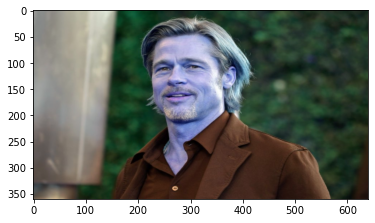

In [365]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv2는 특이하게 RGB가 아니난 BGR 형태를 사용한다. 즉 파란색과 빨간색 계열을 반대로 출력된 것이다.            
이 점에 유의하고 출력전에 RGB 이미지로 바꾸는것을 잊지말아야한다. 

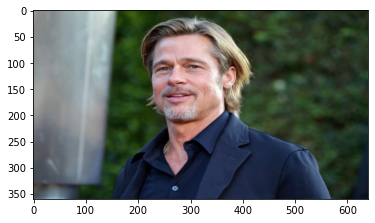

In [366]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


(512, 512, 3)


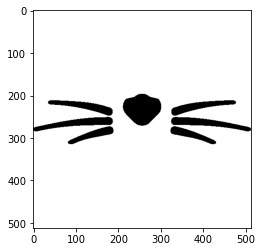

In [367]:
import os

cat_path = os.getenv('HOME') +'/aiffel/camera_sticker/images/cat.png'
img_cat = cv2.imread(cat_path)
plt.imshow(img_cat)
print(img_cat.shape)

## 2. bounding box, landmark 검출 

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 통해 
SVM(Support Vector Machine)의 sliding window를 사용하여 얼굴을 찾는것입니다.  
HOG와 SVM의 자세한 알고리즘은 아래 링크를 보면 알 수 있습니다.. 

[딥러닝(Deep Learning)을 사용한 최신 얼굴 인식(Face Recognition)(한국어 번역본)](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)

[Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning (영어 원본)](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78)

HOG를 간단하게 설명하자면           
gradient는 다변수함수의 각 변수별 1차 미분값의 벡터를 의미합니다.         
이 gradient를 통해서 함수값이 가장 크게 증가하는 방향을 계산할수있고
우리는 이를 얼굴 부분 밝기의 변화를 분석해서 얼굴을 추출할수있습니다.           
한 픽셀이 아닌 16\*16 픽셀단위로 계산한다면 얼굴사진의 noisy에도 robust한 모습을 볼수있습니다.

In [368]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [369]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


num of pyramid라는 aug을 통해서 얼굴을 확대를 해서 찾을수있게 됩니다.     
작은 얼굴도 확대해서 인식가능하게 해주는 기능입니다.

rectangles[[(210, 67) (339, 196)]]


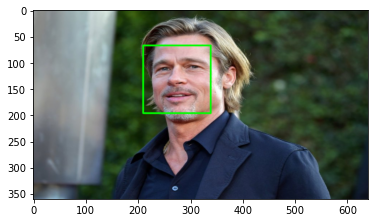

In [370]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

bounding 박스의 좌측 y좌표, 최상단 y좌표, 우측 x좌표, 최하단 y좌표는 (210, 67) (339, 196)로 측정되었습니다.          
bounding box를 찾았으니 landmark도 검출해봅시다.

In [371]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


bounding 박스의 정보가 있는 dliv_rects를 통해서 landmark 포인트를 찾습니다. 랜드마크의 갯수는 총 68개입니다.

In [372]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))



68


브래드 피트의 얼굴에서 68개의 랜드마크 포인트를 찾았음을 확인할수있었습니다.
이 랜드마크는 각 부위별로 index가 존재합니다.

![이미지](https://miro.medium.com/max/414/1*96UT-D8uSXjlnyvs9DZTog.png)

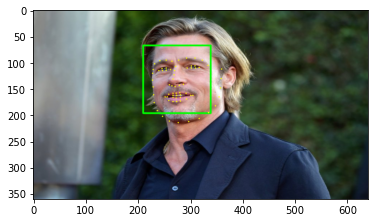

In [373]:
# for landmark in list_landmarks:
for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 1, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

찾아낸 점들에게 원을 그려보았습니다. 명령어는 아래와 같습니다.       
``` python 
cv2.circle(img, center, radian, color, thickness)
```
arguments들은 아래와 같습니다.            
* img – 그림을 그릴 이미지
* center – 원의 중심 좌표(x, y)
* radian – 반지름
* color – BGR형태의 Color
* thickness – 선의 두께, -1 이면 원 안쪽을 채움


img_show에 point들을 중심좌표로 반지름 1픽셀에  BGR이 (0,255,255)의 색으로 원 안쪽을 채우는 명령어를 사용하였습니다.

## 3. 스티커를 지정할 좌표값 지정하기

In [374]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(267, 131)
(x,y) : (267,131)
(w,h) : (130,130)


landmark와 bounding box의 길이를 이용하여 x,y,w,h을 지정했습니다.        
x,y는 landmark index 30 즉 코의 x,y좌표이며 w,h는 bounding box의 너비를 설정하였습니다.             
bounding box가 정사각형이기때문에 w,h의 길이는 같습니다만 개념상 구분되기때문에 따로 지정하였습니다.

(130, 130, 3)


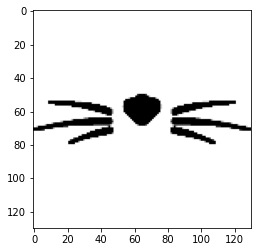

In [375]:
img_cat = cv2.resize(img_cat,(w,h))
plt.imshow(img_cat)
print(img_cat.shape)

아까 불러왔던 고양이 수염 이미지를 위에서 설정했던 w,h의 너비,높이로 리사이즈 합니다.           
130\*130픽셀에 컬러 3채널임을 확인할 수 있습니다.

(130, 130, 3)
130
130
3


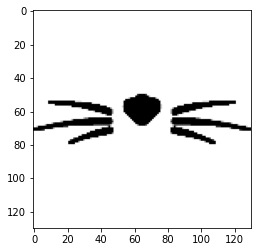

In [376]:
img_cat_rgb = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB)
plt.imshow(img_cat_rgb)
print(img_cat.shape)
print(img_cat.shape[0])
print(img_cat.shape[1])
print(img_cat.shape[2])



img_cat의 shape가 어떤 형태로 되어있는지 다시 한번 확인하였습니다. 

(refined_x,refined_y) : (202,66)
196
332


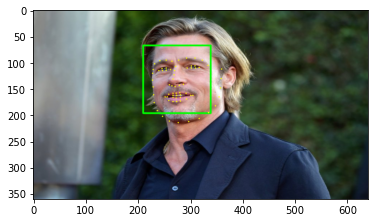

In [377]:
refined_x = int(x-w/2)    # left
refined_y = int(y-w/2)       # top
print ('(refined_x,refined_y) : (%d,%d)'%(refined_x, refined_y))
plt.imshow(img_show_rgb)

print(refined_y+img_cat.shape[0])
print(refined_x+img_cat.shape[1])

코의 x,y좌표에서 w/2만큼 뺀것을 기준이될 refined_x,y로 설정합니다.         
이때 픽셀값들은 정수만 존재하기때문에 int()를 걸어서 정수로 변환합니다.<sup>[1](#footnote_1)</sup>

<a name="footnote_1">1</a>: 가끔 n.0 꼴로 지정되어 정수가 아닌 취급을 받는 오류가 발생해서 강제로 int()를 걸어줬습니다.

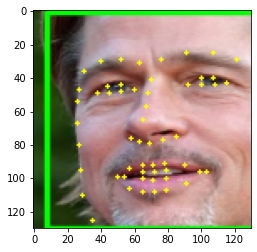

In [378]:
cat_area = img_show[refined_y:refined_y+img_cat.shape[0], 
                       refined_x:refined_x+img_cat.shape[1]]

plt.imshow(cv2.cvtColor(cat_area, cv2.COLOR_BGR2RGB))


# img_show[refined_y:refined_y+img_arrest.shape[0], refined_x:refined_x+img_arrest.shape[1]] = \
#     np.where(img_arrest==0,arrest_area,img_arrest).astype(np.uint8)

## 4. 스티커 적용하기 

우리가 w,h로 img_arrest를 resize 했기 때문에            
img_arrest.shape[0]이나 img_arrest.shape[1]는 w,h와 같은 값입니다. 
고양이 수염 사진을 배치시킬 곳을 나타냈습니다. 
이제 이 구역과 고양이 사진을 np.where을 걸어 일부는 브래드 피트 얼굴이 일부는 고양이 수염이 나오도록 하겠습니다. 

In [379]:
img_show[refined_y:refined_y+img_cat.shape[0], refined_x:refined_x+img_cat.shape[1]] = \
    np.where(img_cat==255,cat_area,img_cat).astype(np.uint8)



img_show의\[refined_y:refined_y+img_cat.shape[0], refined_x:refined_x+img_cat.shape[1]\] 의 부분에       
np.where의 결과물을 지정하는 것입니다.                         
이때 np.where은 (조건,참일때의 넣을 값, 거짓일때의 넣을 값)으로 지정하였습니다.           
이때 조건은 img_cat이 255이냐 이고, img_cat의 값이 255이면 cat_area를, 아니라면 img_cat을 줍니다.

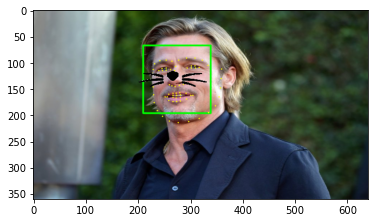

In [380]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 완성
지금 boundig box와 landmark point를 그린곳에 더했기 때문에 boundig box와 landmark도 나타나게되었습니다.          
그러므로 이젠 bounding box와 landmark 표기가 되지 않은곳에 합성해보겠습니다. 

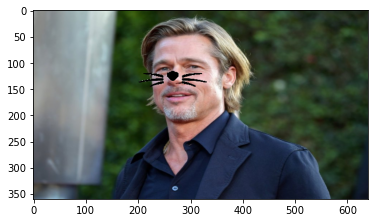

In [381]:
cat_area = img_bgr[refined_y:refined_y+img_cat.shape[0], refined_x:refined_x+img_cat.shape[1]] 
img_bgr[refined_y:refined_y+img_cat.shape[0], refined_x:refined_x+img_cat.shape[1]]  = \
    np.where(img_cat==255,cat_area,img_cat).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

일단 코에 고양이 수염을 합성하는것을 성공하였습니다.          
하지만 우리는 더 고려해야할 것들이 있습니다.    

* 얼굴의 각도 문제  -> 각도에 따라 스티커는 어떻게 변해야 하는가?
* 원거리 촬영했을때의 문제 
* 옆으로 누웠을 때의 문제
* 실행속도가 중요한지의 문제 
* 정확도가 얼마나 중요할지의 문제 

일단 각도의 문제를 해결해보도록 하겠습니다. 

## 6. 문제 고찰

### 6.1 각도 문제
지금까지는 landmark index 30 즉 코를 이용하여 고양의 수염의 위치를 조정하였습니다.       
다음부터는 좀 더 다양하게 볼, 눈, 코, 잎을 이용하여 맞춰보도록 하겠습니다.         
이를 통해서 좌측에 찍힌 얼굴, 우측에서 찍힌 얼굴을 구별해서 수염을 붙도록하겠습니다.


예시를 위해서 **우리가 봤을때** 브래드피트의 **우측 뺨**이 보이는 사진을 준비해보았습니다. 


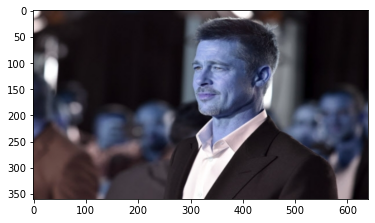

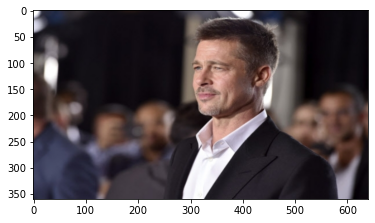

In [382]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/b-0.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()


# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


위와 똑같이 dlib를 이용하여 hog를 활용해서 bounding box를 찾습니다. 

In [383]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [384]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(268, 67) (397, 196)]]


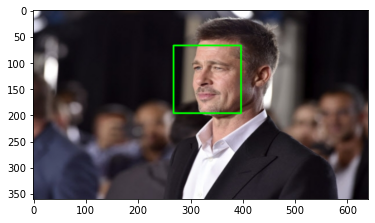

In [385]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

각도가 어느 정도 변해도 bounding box를 잘 찾을 수 있었습니다. 이제 다시 land mark를 찾아봅시다. 

In [386]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


브래드 피트의 얼굴에서 68개의 랜드마크 포인트를 찾았음을 확인할수있었습니다.
이 랜드마크는 각 부위별로 index가 존재합니다.



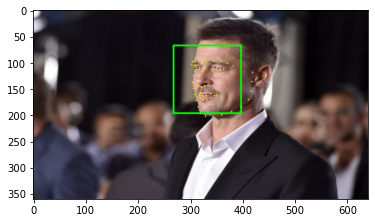

In [387]:
# for landmark in list_landmarks:
for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 1, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* 여기서 **좌측, 우측**은 브래드 피트가 아닌  **찍힌 사진을 보는 우리 입장**입니다. 

**우측 볼**이 들어나는 각도라면 **우측 뺨**이 길게 나타나고 
**좌측 볼**이 들어나는 각도라면 **좌측 뺨**이 길게 나타날 것입니다.

현재 우리가 불러온 사진은 **우측볼** 들어난 자세라 **우측 뺨이 더 길게 나타납니다.**

그렇다면 이 길이를 비교해서 어느 각도를 사용할지 결정할수 있습니다. 

일단 사용할 인덱스의 좌표들을 구합니다. 

![이미지](https://miro.medium.com/max/414/1*96UT-D8uSXjlnyvs9DZTog.png)

중앙부분인 코인 30번을 제외하면 좌측 2번, 36번 48번 index 우측 14번 45번 54번 index를 구했습니다. 

cheek_l (x,y): (304, 137)
eye_l (x,y) (310, 112)
nose (x,y) (314, 135)
mouth_l (x,y) (317, 163)
cheek_r (x,y): (416, 154)
eye_r (x,y) (364, 112)
mouth_r (x,y) (350, 161)
(w,h) : (130,130)


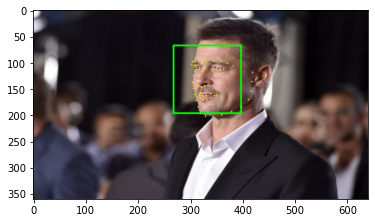

In [388]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print('cheek_l (x,y):' ,landmark[2]) # face edge index : 2
    print('eye_l (x,y)',landmark[36]) # eye index : 36
    print('nose (x,y)', landmark[30]) 
    print('mouth_l (x,y)',landmark[48])
    print('cheek_r (x,y):' ,landmark[14]) # face edge index : 2
    print('eye_r (x,y)',landmark[45]) # eye index : 36
    print('mouth_r (x,y)',landmark[54])
#    print('nose_t (x,y)',landmark[29])
    x_cheek_l = landmark[2][0]
    y_cheek_l = landmark[2][1]
    x_eye_l = landmark[36][0]
    y_eye_l = landmark[36][1]
    x_nose = landmark[30][0]
    y_nose = landmark[30][1]
#     x_nose_t = landmark[29][0]
#     y_nose_t = landmark[29][1]
    x_mouth_l = landmark[48][0]
    y_mouth_l = landmark[48][1]
    x_cheek_r = landmark[14][0]
    y_cheek_r = landmark[14][1]
    x_eye_r = landmark[45][0]
    y_eye_r = landmark[45][1]
    x_mouth_r = landmark[54][0]
    y_mouth_r = landmark[54][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
#    w =  landmark[14][0] - landmark[2][0]  # 양 chick의 넓이 
#    h =  landmark[8][1] - landmark[19][1]  # 턱끝과 눈썹의 높이 
    print ('(w,h) : (%d,%d)'%(w,h))
    
    
plt.imshow(img_show_rgb)


![이미지](https://miro.medium.com/max/414/1*96UT-D8uSXjlnyvs9DZTog.png)

각 볼끝, 눈좌측 끝, 눈 우측 끝, 입 좌측 끝, 입 우측 끝, 눈 우측 끝, 눈 좌측 끝의 좌표를 찾았으며        
w는 양 chick의 너비, h는 턱끝과 눈썹의 높이로 설정하였습니다.  

 랜드마크 index 30과 랜드마크 index14가 더 깁니다.

(130, 130, 3)


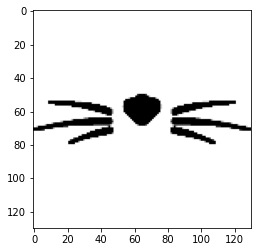

In [389]:
img_cat = cv2.imread(cat_path)
img_cat = cv2.resize(img_cat,(w,h))
plt.imshow(img_cat)
print(img_cat.shape)
img_cat_rgb = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB)
plt.imshow(img_cat_rgb)

In [390]:

## sum([x_cheek,x_eye,x_nose,x_mouth])/len([x_cheek,x_eye,x_nose,x_mouth])


이제 refined_x와 y를 선정해야합니다.  랜드마크 index 30과 랜드마크 index14가 더 깁니다.

196
332


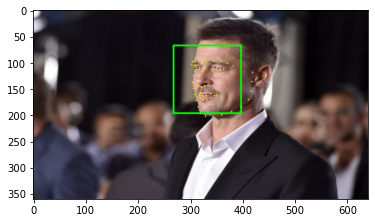

In [391]:
import numpy as np
refined_x_l = int(sum([x_cheek_l,x_eye_l,x_nose,x_mouth_l])/len([x_cheek_l,x_eye_l,x_nose,x_mouth_l])) #- round(w/2)    # left
refined_y_l = int(sum([y_cheek_l,y_eye_l,y_nose,y_mouth_l])/len([y_cheek_l,y_eye_l,y_nose,y_mouth_l])) #- round(h/2)      # top
refined_x_r = int(sum([x_cheek_r,x_eye_r,x_nose,x_mouth_r])/len([x_cheek_r,x_eye_r,x_nose,x_mouth_r])) #- round(w/2)    # left
refined_y_r = int(sum([y_cheek_r,y_eye_r,y_nose,y_mouth_r])/len([y_cheek_r,y_eye_r,y_nose,y_mouth_r])) #- round(h/2)      # top

plt.imshow(img_show_rgb)

print(refined_y+img_cat.shape[0])
print(refined_x+img_cat.shape[1])


좌측 뺨,좌측 눈끝, 코, 좌측 입끝의 평균적인 x,y좌표들           
우측 뺨,좌측 눈끝, 코  우측 입끝의 평균적인 x,y좌표를 구할 수 있었습니다. 

이때 코의 x좌표와 왼쪽 뺨의 x좌표의 차와  코의 x좌표와 오른쫌 뺨의 x좌표를 계산한다면            
어느쪽 뺨이 더 사진에 길게 나오는지 확인할 수 있고 이를 통해 어느쪽 코 land mark를 설정할지 고를 수 있습니다.

In [392]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print('nose_30 (x,y)', landmark[30])
    print('nose_31 (x,y)', landmark[31]) 
    print('nose_32 (x,y)', landmark[32])
    print('nose_33 (x,y)', landmark[33]) 
    print('nose_34 (x,y)', landmark[34]) 
    print('nose_35 (x,y)', landmark[35]) 
    x_nose_30 = landmark[30][0]
    y_nose_30 = landmark[30][1]
    x_nose_31 = landmark[31][0]
    y_nose_31 = landmark[31][1]
    x_nose_32 = landmark[32][0]
    y_nose_32 = landmark[32][1]
    x_nose_33 = landmark[33][0]
    y_nose_33 = landmark[33][1]
    x_nose_34 = landmark[34][0]
    y_nose_34 = landmark[34][1]
    x_nose_35 = landmark[35][0]
    y_nose_35 = landmark[35][1]


nose_30 (x,y) (314, 135)
nose_31 (x,y) (313, 141)
nose_32 (x,y) (316, 144)
nose_33 (x,y) (321, 146)
nose_34 (x,y) (327, 144)
nose_35 (x,y) (334, 143)


만약 x_nose와 x_cheek_l,r과의 거리를 잼으로 어느쪽 뺨이 더 잘나왔는지 확인할수있으며          
이를 통해 고양이 수염의 코의 평균치를 사용할 좌표를 설정합니다.       
좌측뺨이 길게 나왔다면 좌측 코인 30,31,32,33을 이용하여 refined_x,y를 지정하고        
우측뺨이 길게 나왔다면 우측 코인 30,31,34,35를 이용하여 refined_x,y를 지정합니다.

In [393]:
if abs(x_nose - x_cheek_l) > abs(x_nose - x_cheek_r):
    refined_x = int(sum([x_nose_31,x_nose_32,x_nose_33,x_nose_30])/len([x_nose_31,x_nose_32,x_nose_33,x_nose_30]))
    refined_y = int(sum([y_nose_31,y_nose_32,y_nose_33,y_nose_30])/len([x_nose_31,x_nose_32,x_nose_33,x_nose_30]))
    print ('(refined_x,refined_y) : (%d,%d)'%(refined_x, refined_y))
else: 
    refined_x = int(sum([x_nose_34,x_nose_35,x_nose_33,x_nose_30])/len([x_nose_31,x_nose_32,x_nose_33,x_nose_30]))
    refined_y = int(sum([y_nose_34,y_nose_35,y_nose_33,y_nose_30])/len([x_nose_31,x_nose_32,x_nose_33,x_nose_30]))
    print ('(refined_x,refined_y) : (%d,%d)'%(refined_x, refined_y))




(refined_x,refined_y) : (324,142)


In [394]:
print(refined_x,refined_y)
print(x_nose,y_nose)
print((refined_x_l+refined_x_r)/2, (refined_y_l+refined_y_r )/2)

print(x_cheek_l)
w

324 142
314 135
336.0 138.0
304


130

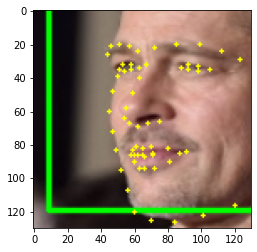

In [395]:
# cat_area = img_show[refined_y-round(h/2):refined_y+round(h/2), 
#                        refined_x-round(w/2):refined_x+round(w/2)]

cat_area = img_show[refined_y-round(h/2):refined_y+round(h/2), 
                       refined_x-round(w/2):refined_x+round(w/2)]

plt.imshow(cv2.cvtColor(cat_area, cv2.COLOR_BGR2RGB))



# img_show[refined_y:refined_y+img_arrest.shape[0], refined_x:refined_x+img_arrest.shape[1]] = \
#     np.where(img_arrest==0,arrest_area,img_arrest).astype(np.uint8)

In [396]:
# arrest_area = img_show[refined_y_l-round(h/2):refined_y_l+round(w/2), 
#                        refined_x_l-round(w/2):refined_x_r+round(w/2)]

cat_area = img_show[refined_y-round(h/2):refined_y+round(h/2), 
                       refined_x-round(w/2):refined_x+round(w/2)]

img_show[refined_y-round(h/2):refined_y+round(h/2), 
                       refined_x-round(w/2):refined_x+round(w/2)]= \
     cv2.addWeighted(cat_area, 0.1, np.where(img_cat==255,cat_area,img_cat).astype(np.uint8), 0.9, 0)



``` python
cv2.addWeighted(imgA,a,imgB,b)
```

cv2.addWeighted(imgA,a,imgB,b)를 통해 더 자연스럽게 합성할 수 있습니다.           
이때 결과 이미지는 아래 식과 같게 됩니다. 

result = imgA * a + imgB * b + c

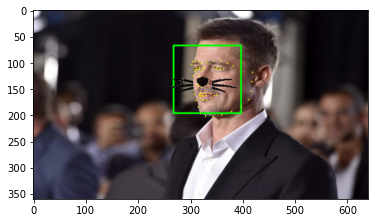

In [397]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

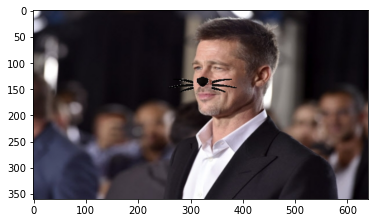

In [398]:
cat_area = img_bgr[refined_y-round(h/2):refined_y+round(h/2), 
                       refined_x-round(w/2):refined_x+round(w/2)]
img_bgr[refined_y-round(h/2):refined_y+round(h/2), 
                       refined_x-round(w/2):refined_x+round(w/2)]= \
     cv2.addWeighted(cat_area, 0.1, np.where(img_cat==255,cat_area,img_cat).astype(np.uint8), 0.9, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 6.2 여러 사람 얼굴 검출

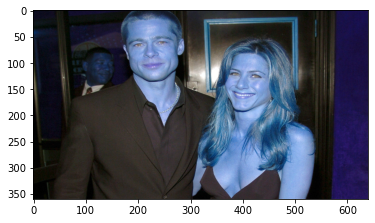

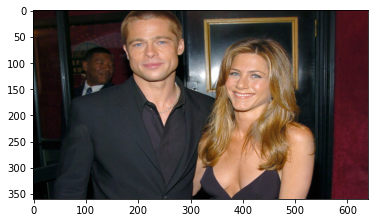

In [399]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/b-5.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [400]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [401]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


num of pyramid라는 aug을 통해서 얼굴을 확대를 해서 찾을수있게 됩니다.     
작은 얼굴도 확대해서 인식가능하게 해주는 기능입니다.

rectangles[[(175, 36) (265, 126)], [(112, 84) (164, 136)], [(364, 96) (454, 186)]]


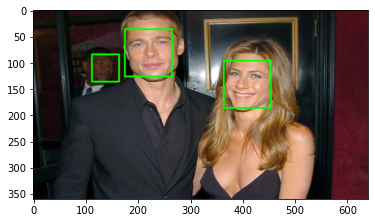

In [402]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [403]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

print(len(list_landmarks[1])) 

print(len(list_landmarks[2]))



68
68
68


이전과의 차이점은 3사람이기 때문에 list_landmark가 [0]뿐만 아니라 [1]과 [2]를 가지고 있다. 

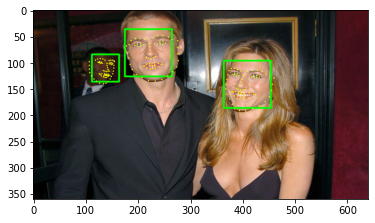

In [404]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 1, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks에서 for문을 돌리고 다시 한번 더 for문을 돌리면 3명 다 잘 적합됨을 확인 할 수있었다. 

In [405]:
x =[]
y =[]
w = []
h = []
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x.append(landmark[30][0])
    y.append(landmark[30][1])
    w.append(dlib_rect.width())
    h.append(dlib_rect.width())
    
print(x)
print(y)
print(w)
print(h)

(223, 83)
(143, 113)
(394, 144)
[223, 143, 394]
[83, 113, 144]
[91, 53, 91]
[91, 53, 91]


각각 코의 랜드마크 위치와, bounding box의 w와 h를 구할 수 있었습니다.      
3명이 존재하기 때문에 고양이 수염 이미지도 3개를 준비합니다.

(91, 91, 3)
(53, 53, 3)
(53, 53, 3)


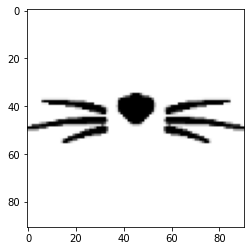

In [406]:
img_cat_0 = cv2.resize(img_cat,(w[0],h[0]))
plt.imshow(img_cat_0)
print(img_cat_0.shape)

img_cat_1 = cv2.resize(img_cat,(w[1],h[1]))
plt.imshow(img_cat_1)
print(img_cat_1.shape)

img_cat_2 = cv2.resize(img_cat,(w[2],h[2]))
plt.imshow(img_cat_2)
print(img_cat_1.shape)

In [407]:
refined_x = []
refined_y = []
for i in range(3):
    refined_x.append(int(x[i]-w[i]/2))
    refined_y.append(int(y[i]-w[i]/2))

print(refined_x,refined_y)

[177, 116, 348] [37, 86, 98]


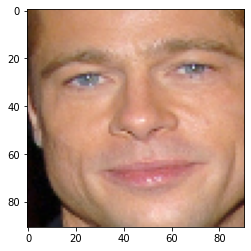

In [416]:
cat_area_0 = img_bgr[refined_y[0]:refined_y[0]+img_cat_0.shape[0], 
                       refined_x[0]:refined_x[0]+img_cat_0.shape[1]]

plt.imshow(cv2.cvtColor(cat_area_0, cv2.COLOR_BGR2RGB))




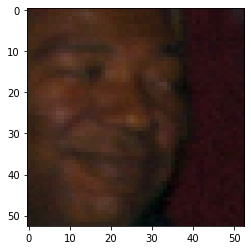

In [417]:
cat_area_1 = img_bgr[refined_y[1]:refined_y[1]+img_cat_1.shape[0], 
                       refined_x[1]:refined_x[1]+img_cat_1.shape[1]]

plt.imshow(cv2.cvtColor(cat_area_1, cv2.COLOR_BGR2RGB))



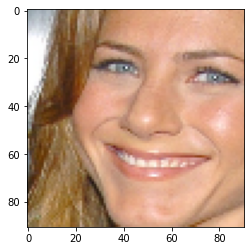

In [418]:


cat_area_2 = img_bgr[refined_y[2]:refined_y[2]+img_cat_2.shape[0], 
                       refined_x[2]:refined_x[2]+img_cat_2.shape[1]]

plt.imshow(cv2.cvtColor(cat_area_2, cv2.COLOR_BGR2RGB))

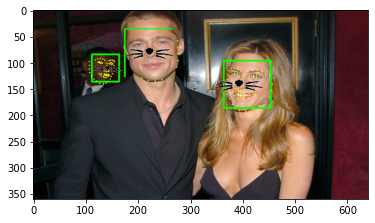

In [419]:
img_show[refined_y[0]:refined_y[0]+img_cat_0.shape[0], 
                       refined_x[0]:refined_x[0]+img_cat_0.shape[1]] = \
    np.where(img_cat_0==255,cat_area_0,img_cat_0).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

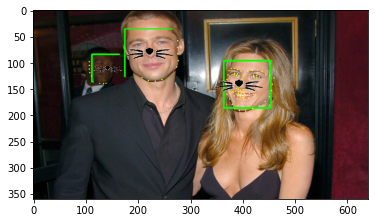

In [420]:
img_show[refined_y[1]:refined_y[1]+img_cat_1.shape[0], 
                       refined_x[1]:refined_x[1]+img_cat_1.shape[1]] = \
    np.where(img_cat_1==255,cat_area_1,img_cat_1).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

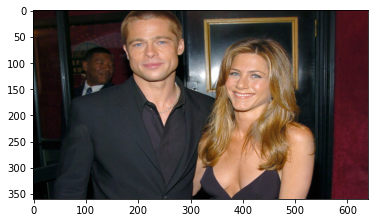

In [421]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))


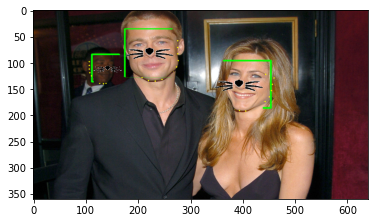

In [422]:
img_show[refined_y[2]:refined_y[2]+img_cat_2.shape[0], 
                       refined_x[2]:refined_x[2]+img_cat_2.shape[1]] = \
    np.where(img_cat_2==255,cat_area_2,img_cat_2).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

3명 다 잘 적합되었습니다. 이제 완성시켜보겠습니다.

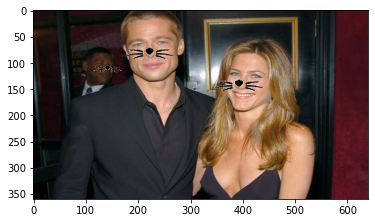

In [423]:
img_bgr[refined_y[0]:refined_y[0]+img_cat_0.shape[0], 
                       refined_x[0]:refined_x[0]+img_cat_0.shape[1]] = \
    np.where(img_cat_0==255,cat_area_0,img_cat_0).astype(np.uint8)

img_bgr[refined_y[1]:refined_y[1]+img_cat_1.shape[0], 
                       refined_x[1]:refined_x[1]+img_cat_1.shape[1]] = \
    np.where(img_cat_1==255,cat_area_1,img_cat_1).astype(np.uint8)


img_bgr[refined_y[2]:refined_y[2]+img_cat_2.shape[0], 
                       refined_x[2]:refined_x[2]+img_cat_2.shape[1]] = \
    np.where(img_cat_2==255,cat_area_2,img_cat_2).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

3인에게 모두 적합시킬수 있었습니다.     
상대적으로 원거리에 있고, 어두운 곳에서 찍힌 뒷분도 잘 적합됨을 확인 할 수 있었습니다. 

## 6.3 회전된 얼굴 검출 
### 완벽한 측면 


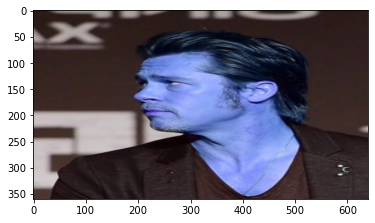

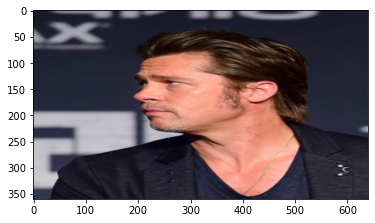

In [426]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/b_1.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [427]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [428]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[]


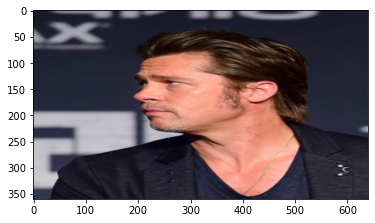

In [429]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
완벽한 측면의 경우 bounding box의 검출을 실패하였습니다. 

### 90도 회전

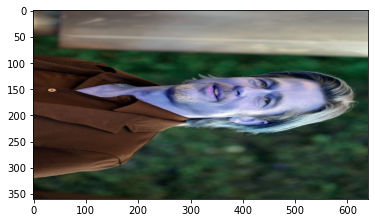

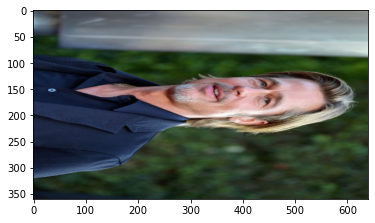

In [431]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/b_rot90.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [432]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [433]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[]


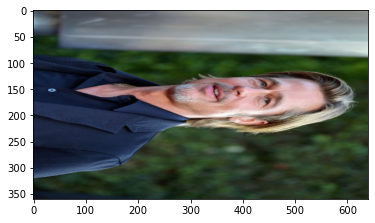

In [434]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

90도 회전한 이미지에서도 bounding box의 형성을 실패하였습니다. 

### 180도 회전 

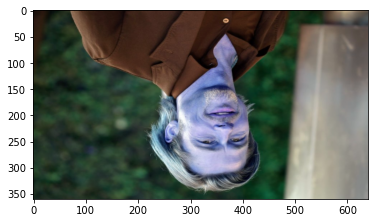

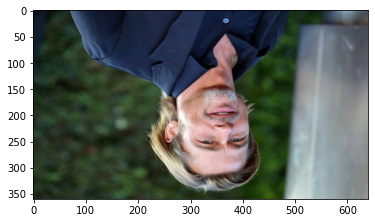

In [435]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/b_rot180.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [436]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [437]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[]


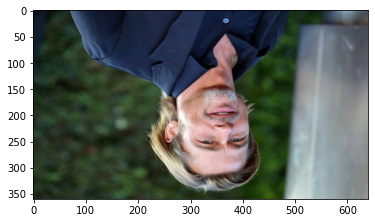

In [438]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

180도로 회전한 사진 역시 bounding box의 산출을 실패하였습니다. 

### 회전된 이미지 해결책

cv2.getRotationMatrix2D(center, angle, scale) 을 이용해보도록 하겠습니다.

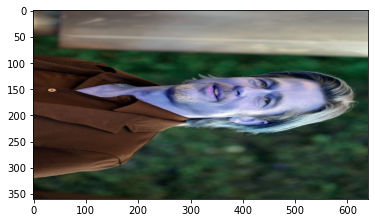

In [445]:
rows, cols = img_show.shape[:2]

# 이미지의 중심점을 기준으로 90도 회전 하면서 1배 Scale
M= cv2.getRotationMatrix2D((cols/2, rows/2),90, 1)

dst = cv2.warpAffine(img_show, M,(cols, rows))

plt.imshow(img_show)



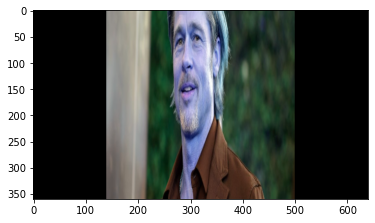

In [444]:
plt.imshow(dst)

이런식으로 회전된 얼굴이라면 이미지를 회전시켜서 일반적인 각도로 만들수있을 것입니다.                     
이후 이전에 진행하였던 방식을 그대로 사용하면 고양이 수염 스티커를 붙일 수 있습니다.                    
하지만 각도를 정확히 어떤식으로 계산해야하는지에 대해서는 아직 잘 모르겠습니다.        

## 회고
제 셀카는 정상적인 사진도 아무리 반복해도 bounding box부터 제대로 잡히지 않아 브래드 피트의 얼굴을 사용했습니다.              
그래서 멀리서 찍은 사진, 밝기가 다른 사진은 제대로 구하지 못했지만 
마지막 3인 검출에서 
다소 멀리있고 어두운곳에서 찍힌 흑인분을 통해서 어느정도 구현하려고 노력했습니다.

최대한 다양한 방법을 사용해보려 했지만 여러 시도들이 실패하는 바람에 코드 정리도 제대로 하지 못한채로          
주로 코에다 중심을 놓고 w,h만큼 좌표를 넓혀서 계산하게 되었다.  
많이 아쉽습니다.

얼굴이 어느정도 회전된 경우 고양이 수염도 회전시키는 방법을 구사하려 했지만           
cv2.getRotationMatrix2D(center, angle, scale)                                         
cv2.getAffineTransform(pts1, pts2)                   
cv2.warpAffine(img, M, (cols,rows))                   

등의 명령어를 찾아냈지만 정확한 사용 방법에 대해서는 알지 못했습니다.   

그리고 회전된 얼굴이미지일때 조절하는 각도를 어떻게 계산하 getRotationMatrix2D의 aug로 넣는지를 잘 모르겠습니다.

회전된 얼굴을 정면으로 변형하는 기술도 조사해보았지만
openface라는 library가 설치하는 중 오류가 발생하여 제대로 하지 못했습니다.


제가 많이 부족했고 아쉬움이 많이 남는 활동이었습니다. 